In [57]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc as misc 
from scipy.signal import resample
from astropy.io import fits
import scipy.io as sio

import optimusprimal.primal_dual as primal_dual
import optimusprimal.grad_operators as grad_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.prox_operators as prox_operators

import optimusprimal as optpr
import ProxNest as prn
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

In [58]:
# Auxiliary functions

def eval_snr(x, x_est):
    if np.array_equal(x, x_est):
        return 0
    num = np.sqrt(np.sum(np.abs(x) ** 2))
    den = np.sqrt(np.sum(np.abs(x - x_est) ** 2))
    return round(20*np.log10(num/den), 2)



First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [59]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}

## Load image

INSTRUME                                                                         [astropy.io.fits.card]


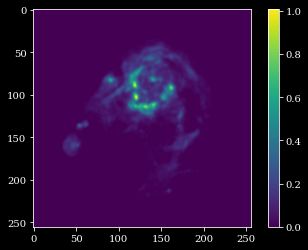

In [60]:
img_path = './../data/imgs/M31.fits'

img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img
 
plt.figure()
plt.imshow(img);plt.colorbar()
plt.show()


In [133]:
op_mask = sio.loadmat('./../data/operators_masks/fourier_mask.mat')['Ma']

In [134]:
op_mask.shape

(6512, 65536)

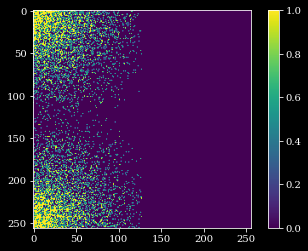

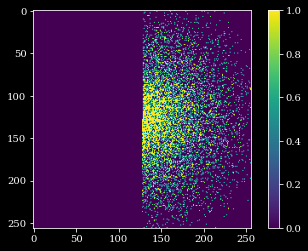

In [135]:
# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

plt.figure()
plt.imshow(mat_mask);plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.fft.ifftshift(mat_mask));plt.colorbar()
plt.show()

In [136]:
mat_mask.dtype

dtype('bool')

In [119]:
phi2 = operators.sensing_operators.MaskedFourier(dim, 0.5)


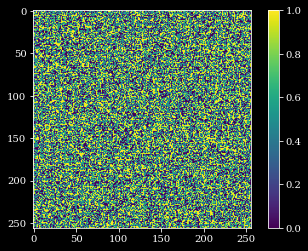

In [120]:
plt.figure()
plt.imshow(phi2.mask);plt.colorbar()
plt.show()

In [137]:
dim = img.shape[0]

# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)
# Use X. Cai's Fourier mask
phi.mask = mat_mask

# Simulate mock noisy observations y
y = phi.dir_op(img)
ISNR = 25
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)


rng = np.random.default_rng(seed=0)

n = rng.normal(0, sigma, y.shape)

# Simulate mock noisy observations
y += n

x_init = np.abs(phi.adj_op(y))


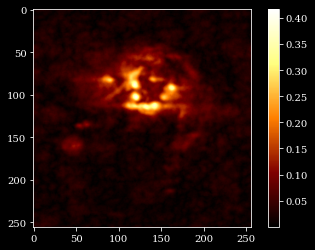

In [139]:
plt.figure()
plt.imshow(x_init, cmap='afmhot');plt.colorbar()
plt.show()

## wavelet-based UQ

# Primal-dual alg


In [140]:
## Primal-dual FB Wavelet-based denoiser

reg_param = 2.5e-2

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db8"]# ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 4 # 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param, psi)
h.beta = 1.0

# Real prox 
r = optpr.prox_operators.real_prox()
# f = None


In [86]:
np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) #* reg_param

2.6463760962475584

In [141]:
# Run the alg

wvlt_best_estimate, wvlt_diagnostics = optpr.primal_dual.FBPD(
    x_init=x_init, options=options, g=g, f=None, h=h, r=r
)


2023-02-16 19:21:36,185 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-02-16 19:21:36,216 - Optimus Primal - INFO - [Primal Dual] 0 out of 5000 iterations, tol = 0.039897
2023-02-16 19:21:37,255 - Optimus Primal - INFO - [Primal Dual] 50 out of 5000 iterations, tol = 0.003181
2023-02-16 19:21:38,583 - Optimus Primal - INFO - [Primal Dual] 100 out of 5000 iterations, tol = 0.000633
2023-02-16 19:21:39,661 - Optimus Primal - INFO - [Primal Dual] 150 out of 5000 iterations, tol = 0.000135
2023-02-16 19:21:40,738 - Optimus Primal - INFO - [Primal Dual] 200 out of 5000 iterations, tol = 0.000045
2023-02-16 19:21:41,886 - Optimus Primal - INFO - [Primal Dual] 250 out of 5000 iterations, tol = 0.000021
2023-02-16 19:21:42,716 - Optimus Primal - INFO - [Primal Dual] converged in 291 iterations


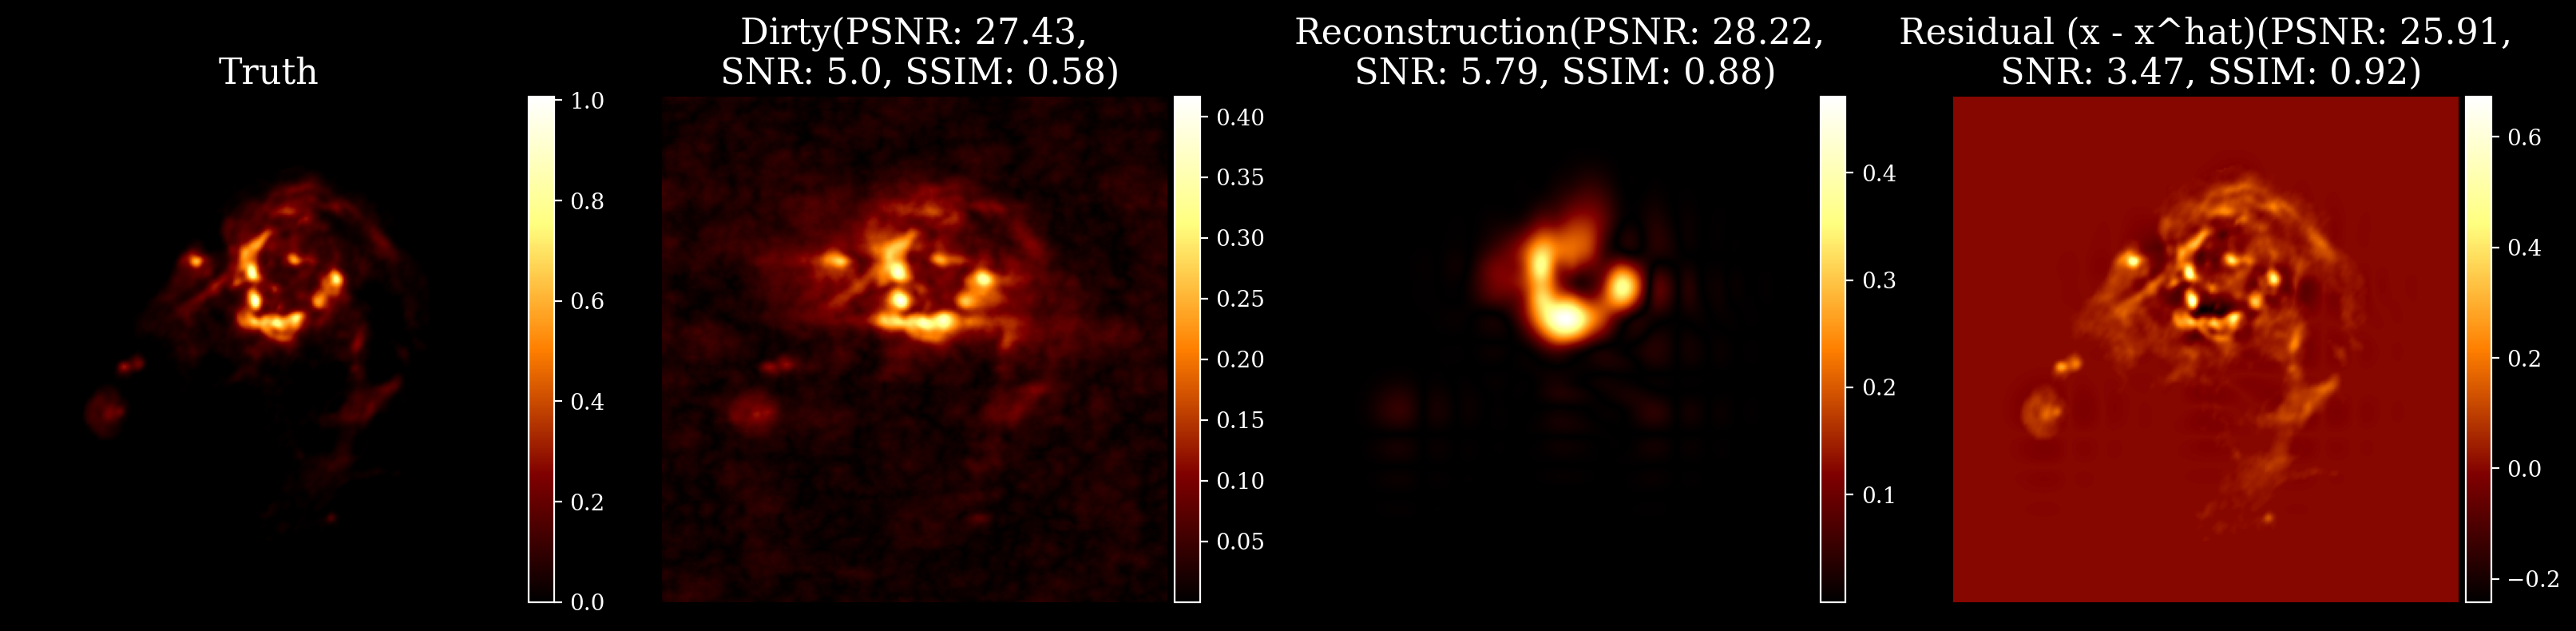

In [143]:
images = [x, x_init, np.abs(wvlt_best_estimate), x-np.abs(wvlt_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i],data_range=ground_truth.max()-ground_truth.min()), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()

## Compute HPD region

In [23]:
x_hat_np = np.abs(wvlt_best_estimate)


alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

reg_fun = lambda h, x: h.fun(h.dir_op(x))

gamma_alpha = g.fun(x_hat_np) + reg_fun(h, x_hat_np) + tau_alpha*np.sqrt(N) + N

loss_fun = lambda x_map : g.fun(x_map) +  reg_fun(h, x_hat_np)


In [24]:
print(
    'f(x_map): ', g.fun(x_hat_np),
    ', g(x_map): ', reg_fun(h, x_hat_np),
    'tau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    'N: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  351792.2477749056 , g(x_map):  17.112526191267992 tau_alpha*np.sqrt(N):  2445.577521189034 N:  65536
N:  65536
tau_alpha:  9.553037192144664
gamma_alpha:  419790.9378222859


In [26]:
vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))
err_vmax= 0.6

2023-02-16 17:33:45,720 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-16 17:33:46,899 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.042729618900921196, 0.058183521730825305) with sum 1.4629006913815934
2023-02-16 17:33:47,715 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.05747572227846831, 0.04387013509403914) with sum 1.773562536673396
2023-02-16 17:33:48,421 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.05079742276575416, 0.04961100348737091) with sum 4.895725728408821
2023-02-16 17:33:49,080 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.056398864137008786, 0.04708898882381618) with sum 12.399063083721888
2023-02-16 17:33:49,745 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.05657499725930393, 0.044909298536367714) with sum 3.896738597653644
2023-02-16 17:33:50,426 - Optimus Primal - INFO - [Credible Interval] (0, 5) has 

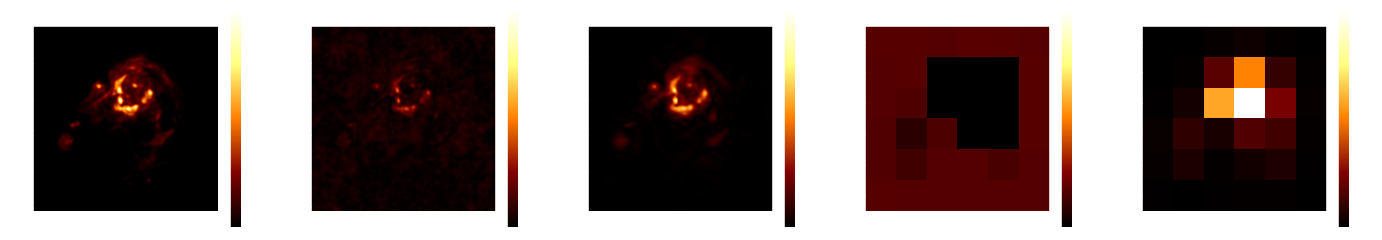

2023-02-16 17:34:07,311 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-16 17:34:08,123 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.05586244788719341, 0.07631581404712051) with sum 0.4809442200613962
2023-02-16 17:34:08,919 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.06916685285978019, 0.06191305362153798) with sum 0.8847105803015536
2023-02-16 17:34:09,672 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.06571526150219142, 0.06506590789649636) with sum 0.8963462479467584
2023-02-16 17:34:10,422 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.06662702327594161, 0.06448833760805428) with sum 2.762385144106669
2023-02-16 17:34:11,183 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.07003021007403731, 0.06274013116490096) with sum 6.0238898402024805
2023-02-16 17:34:11,896 - Optimus Primal - INFO - [Credible Interval] (0, 5) has in

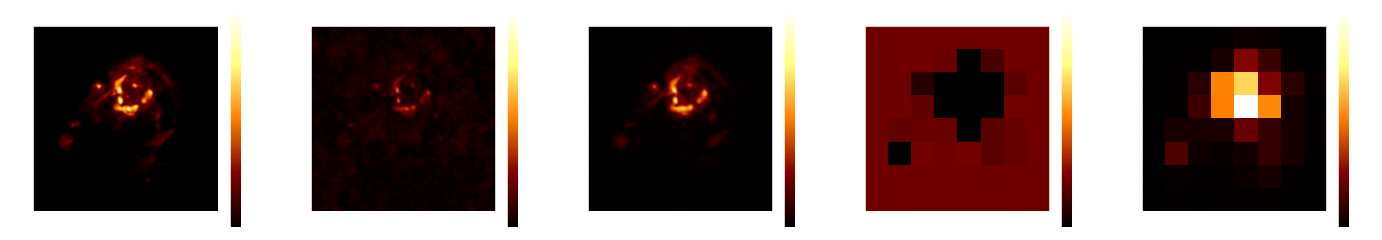

2023-02-16 17:34:50,413 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-16 17:34:51,235 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.08536271716002375, 0.10910060815513134) with sum 0.05722598912201242
2023-02-16 17:34:51,971 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.09307580022141337, 0.10006857686676085) with sum 0.21804506595949513
2023-02-16 17:34:52,746 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.10305591637734324, 0.09049467707518488) with sum 0.15837946566883604
2023-02-16 17:34:53,489 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.09676074027083814, 0.09631450567394495) with sum 0.1365278515061567
2023-02-16 17:34:54,243 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.09989262721501291, 0.0933213938260451) with sum 0.26844521367777985
2023-02-16 17:34:54,970 - Optimus Primal - INFO - [Credible Interval] (0, 5) ha

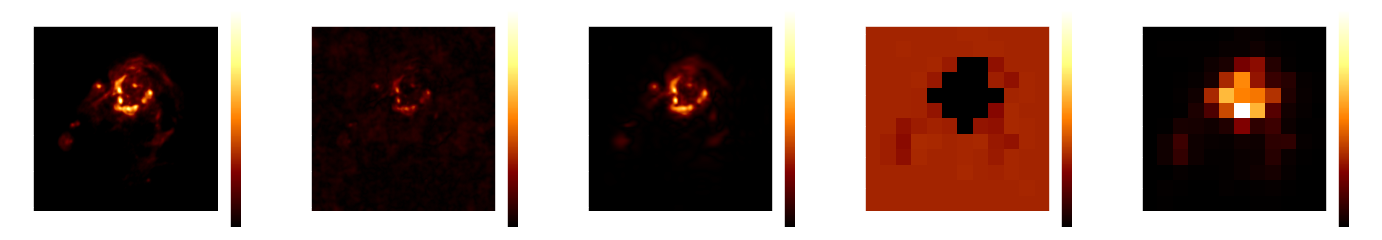

2023-02-16 17:36:29,184 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-16 17:36:29,959 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.1742622300516814, 0.21497503598220646) with sum 0.005404356219327026
2023-02-16 17:36:30,695 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.1816737363114953, 0.20619117212481797) with sum 0.01819316322850181
2023-02-16 17:36:31,448 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.188802509335801, 0.19841720187105238) with sum 0.05055085377411933
2023-02-16 17:36:32,152 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.18935807328671217, 0.19782616989687085) with sum 0.05262974822826676
2023-02-16 17:36:32,867 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.19067162717692554, 0.19648120063357055) with sum 0.013414013911902285
2023-02-16 17:36:33,618 - Optimus Primal - INFO - [Credible Interval] (0, 5) ha

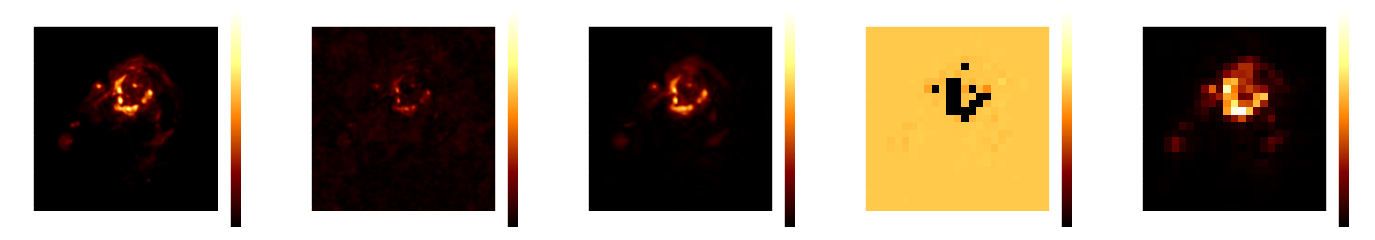

In [27]:


error_p_40, error_m_40, mean_40 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=40,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_40 = error_p_40 - error_m_40

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_40, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_40, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_40_v2.pdf')
plt.show()


error_p_30, error_m_30, mean_30 = optpr.map_uncertainty.create_local_credible_interval(
x_sol=x_hat_np,
region_size=30,
function=loss_fun,
bound=gamma_alpha,
iters=200,
tol=1e-4,
bottom=-1,
top=2,
)
error_length_30 = error_p_30 - error_m_30

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_30, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_30, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_30_v2.pdf')
plt.show()

error_p_20, error_m_20, mean_20 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=20,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1,
    top=2,
)
error_length_20 = error_p_20 - error_m_20

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_20_v2.pdf')
plt.show()


error_p_10, error_m_10, mean_10 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=10,
    function=loss_fun,
    bound=gamma_alpha,
    iters=200,
    tol=1e-4,
    bottom=-1,
    top=2,
)
error_length_10 = error_p_10 - error_m_10

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_10, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_10, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_10_v2.pdf')
plt.show()



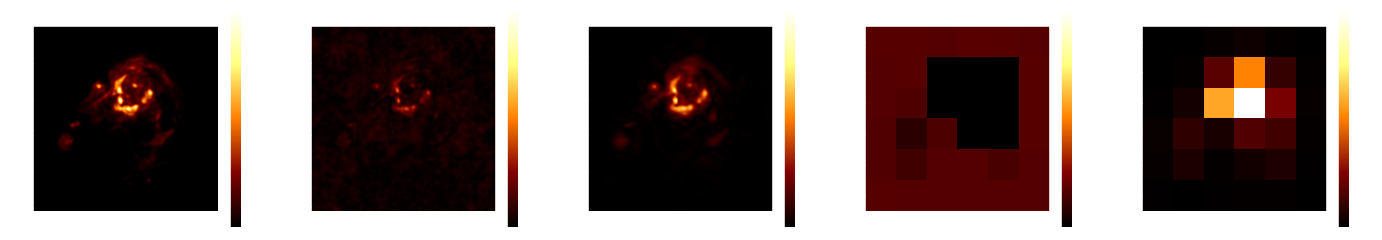

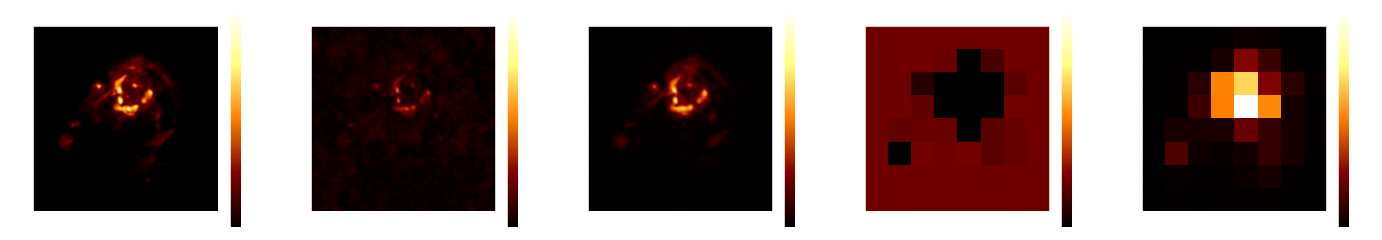

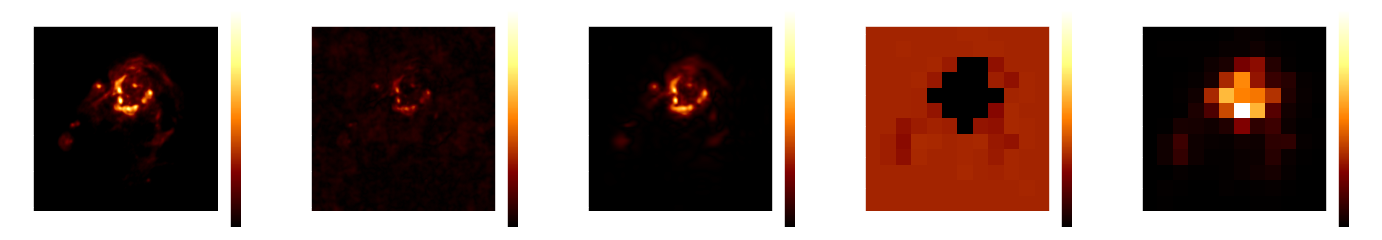

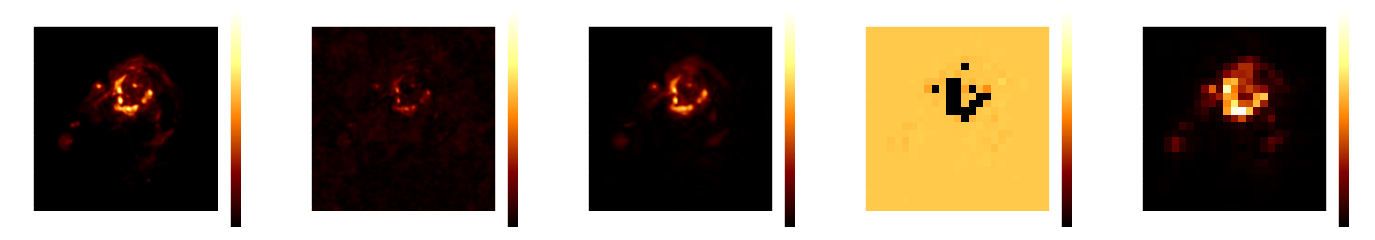

In [16]:
plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_40, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_40, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_40.pdf')
plt.show()


plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_30, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_30, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_30.pdf')
plt.show()


plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_20.pdf')
plt.show()


plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_10, cmap='afmhot', vmin=0, vmax=err_vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_10, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/M31_256_wavelet-reg_superpix_10.pdf')
plt.show()



### Compute the MAP


In [8]:
reg_param_FB = 5e-2

# Define the grad
g = optpr.grad_operators.l2_norm(sigma, y, phi)
g.beta = 1.0 / sigma ** 2

# Define the wavelet dict
wav = ["db1", "db4"]                                     # Wavelet dictionaries to combine
levels = 3                                               # Wavelet levels to consider [1-6]
psi = optpr.linear_operators.dictionary(wav, levels, x.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h = optpr.prox_operators.l1_norm(np.max(np.abs(psi.dir_op(abs(phi.adj_op(y))))) * reg_param_FB, psi)
h.beta = 1.0

# Real prox 
f = optpr.prox_operators.real_prox()
# f = None


In [9]:
# Run the alg

# Run the alg
alpha = 2 / (g.beta + 2)
wvlt_FB_best_estimate, wvlt_FB_diagnostics = optpr.forward_backward.FB(
    x_init=x_init, options=options, g=g, f=f, h=h, alpha=alpha, tau=1
)

wvlt_FB_best_estimate = np.abs(wvlt_FB_best_estimate)



2023-02-13 15:53:25,403 - Optimus Primal - INFO - Running Base Forward Backward
2023-02-13 15:53:25,497 - Optimus Primal - INFO - [Forward Backward] 0 out of 5000 iterations, tol = 0.571888
2023-02-13 15:53:25,638 - Optimus Primal - INFO - [Forward Backward] converged in 42 iterations


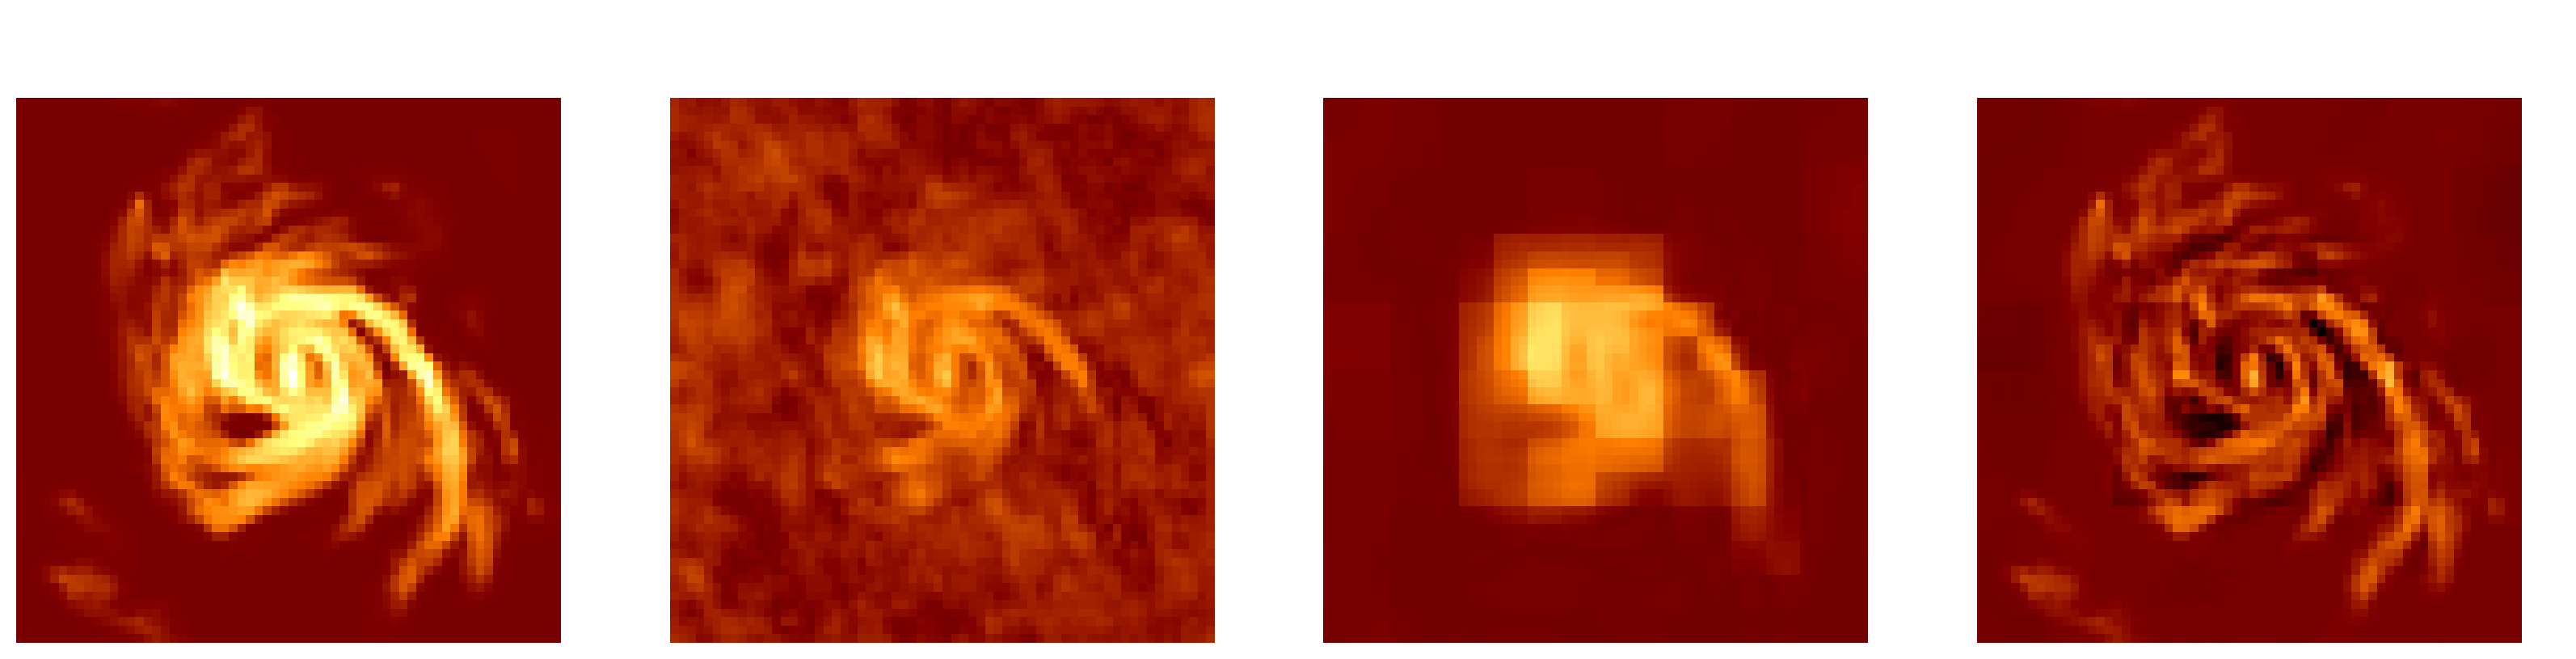

In [10]:
images = [x, x_init, np.abs(wvlt_FB_best_estimate), x-np.abs(wvlt_FB_best_estimate)]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = '(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i]), 2),
            round(eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i]), 2),
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

plt.show()


-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


<ipython-input-116-4f0fd10070e4>:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr(ground_truth, images[i]),
/Users/tliaudat/miniconda3/envs/convex_uq/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


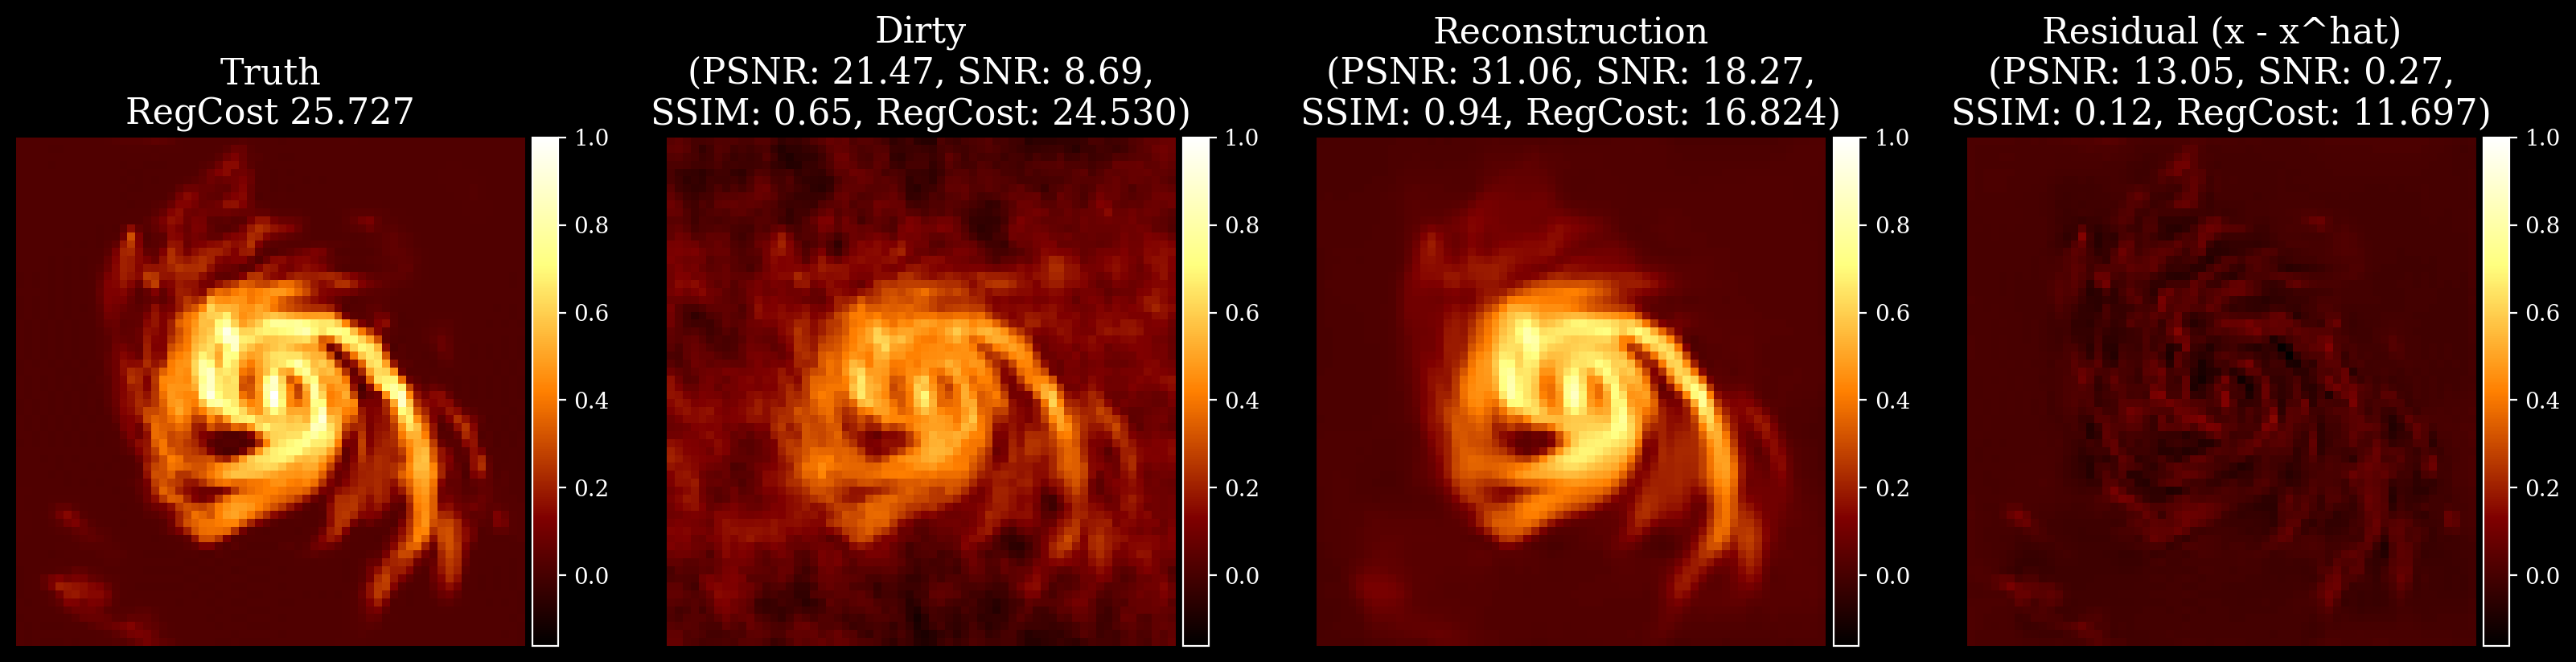

In [116]:
x_hat_np = x_hat.detach().cpu().squeeze().numpy()

images = [x, x_init, x_hat_np, x-np.abs(x_hat_np)]
images_torch = [x_torch, x_init_torch, x_hat, x_torch-x_hat]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='afmhot', vmax=np.nanmax(images), vmin=np.nanmin(images))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(mu * images_torch[i])[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(ground_truth, images[i]),
            eval_snr(x, images[i]),
            ssim(ground_truth, images[i]),
            model.cost(mu * images_torch[i])[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
plt.show()

### Compute HPD region

In [76]:
alpha = 0.01
N = x_hat_np.size
tau_alpha = np.sqrt(16*np.log(3/alpha))

prior_fun = lambda model, x_hat, mu, lambda_param : (lambda_param/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False))

# gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu*torch.tensor(x_hat, device=device, dtype=myType, requires_grad=False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N

gamma_alpha = g.fun(x_hat_np) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy() + tau_alpha*np.sqrt(N) + N


loss_fun = lambda x_map : g.fun(x_map) + (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy()


In [123]:

print(
    'f(x_map): ', g.fun(x_hat_np),
    ', g(x_map): ', (lmbd/mu) * model.cost(mu * x_hat.clone().detach().requires_grad_(False)).detach().cpu().squeeze().numpy(),
    'tau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
    'N: ', N,
)
print('N: ', N)
print('tau_alpha: ', tau_alpha)
print('gamma_alpha: ', gamma_alpha)

f(x_map):  2765.181858574208 , g(x_map):  2.5236671447753904 tau_alpha*np.sqrt(N):  2445.577521189034 N:  65536
N:  65536
tau_alpha:  9.553037192144664
gamma_alpha:  170512.44416505328


In [78]:
error_p_20, error_m_20, mean_20 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=20,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_20 = error_p_20 - error_m_20

2023-02-13 14:01:48,707 - Optimus Primal - INFO - Calculating credible interval for (256, 256) superpxiels.
2023-02-13 14:01:59,077 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.18708070693537593, 0.1937292842194438) with sum 0.22462681
2023-02-13 14:02:09,282 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.18943569576367736, 0.19136962154880166) with sum 0.38651627
2023-02-13 14:02:19,289 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.18530870880931616, 0.19554684264585376) with sum 0.5431942
2023-02-13 14:02:30,610 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.1886284693609923, 0.1921971240080893) with sum 0.593326
2023-02-13 14:02:45,428 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.190088257426396, 0.1900817323476076) with sum 2.6574893
2023-02-13 14:03:02,813 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.15816169860772789, 0.22087574703618884

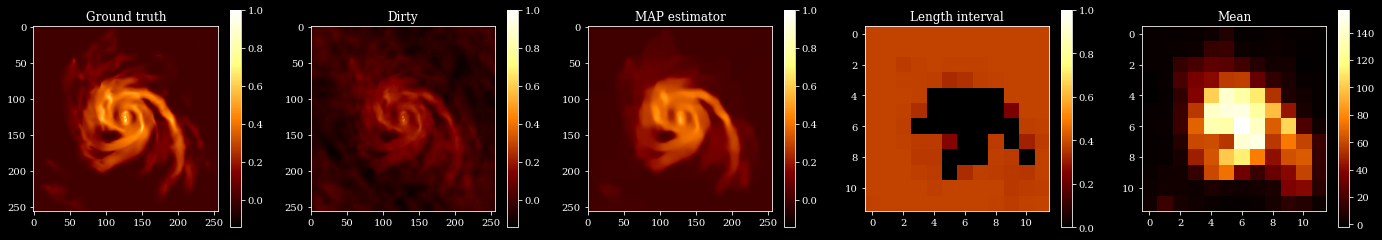

In [89]:
vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_20, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_20, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_256_CCR-reg_superpix_20.pdf')
plt.show()

In [65]:

#  x_sol, region_size, function, bound, iters, tol, bottom, top
# error_p_2, error_m_2, mean_2 = optpr.map_uncertainty.create_local_credible_interval(
#     x_sol=x_hat_np,
#     region_size=2,
#     function=loss_fun,
#     bound=gamma_alpha,
#     iters=200,
#     tol=1e-4,
#     bottom=-1.,
#     top=2.,
# )
# error_length_2 = error_p_2 - error_m_2

error_p_4, error_m_4, mean_4 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=4,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_4 = error_p_4 - error_m_4


error_p_8, error_m_8, mean_8 = optpr.map_uncertainty.create_local_credible_interval(
    x_sol=x_hat_np,
    region_size=8,
    function=loss_fun,
    bound=gamma_alpha,
    iters=400,
    tol=1e-4,
    bottom=-1.,
    top=2.,
)
error_length_8 = error_p_8 - error_m_8

# np.sqrt(np.sum(x_hat_np**2)/x_hat_np.size)


2023-02-13 13:43:56,420 - Optimus Primal - INFO - Calculating credible interval for (64, 64) superpxiels.
2023-02-13 13:43:56,898 - Optimus Primal - INFO - [Credible Interval] (0, 0) has interval (-0.36372319608926773, 0.3536841347813606) with sum -0.029400336
2023-02-13 13:43:57,266 - Optimus Primal - INFO - [Credible Interval] (0, 1) has interval (-0.35999583452939987, 0.35730331391096115) with sum -0.04745282
2023-02-13 13:43:57,629 - Optimus Primal - INFO - [Credible Interval] (0, 2) has interval (-0.369014672935009, 0.3483160212635994) with sum -0.08605468
2023-02-13 13:43:58,006 - Optimus Primal - INFO - [Credible Interval] (0, 3) has interval (-0.37268760800361633, 0.3448195308446884) with sum -0.09325599
2023-02-13 13:43:58,346 - Optimus Primal - INFO - [Credible Interval] (0, 4) has interval (-0.3668326362967491, 0.3503881171345711) with sum -0.071997985
2023-02-13 13:43:58,762 - Optimus Primal - INFO - [Credible Interval] (0, 5) has interval (-0.3602312207221985, 0.3571401014

In [64]:
# error_length_4_it_200 = np.copy(error_length_4)
# mean_4_it_200 = np.copy(mean_4)

In [118]:
x.shape

(64, 64)

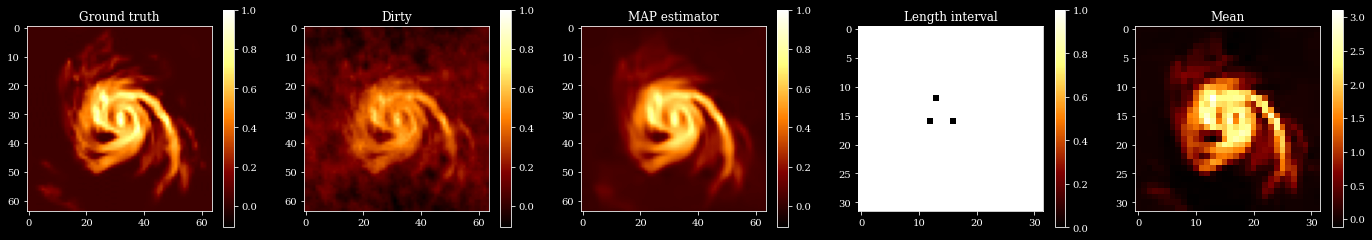

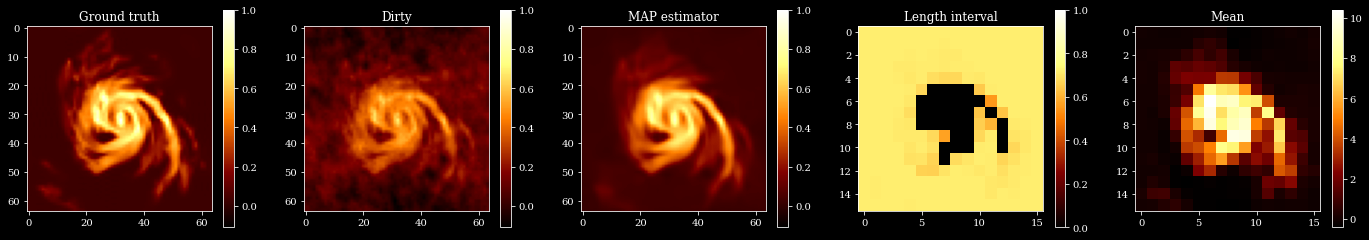

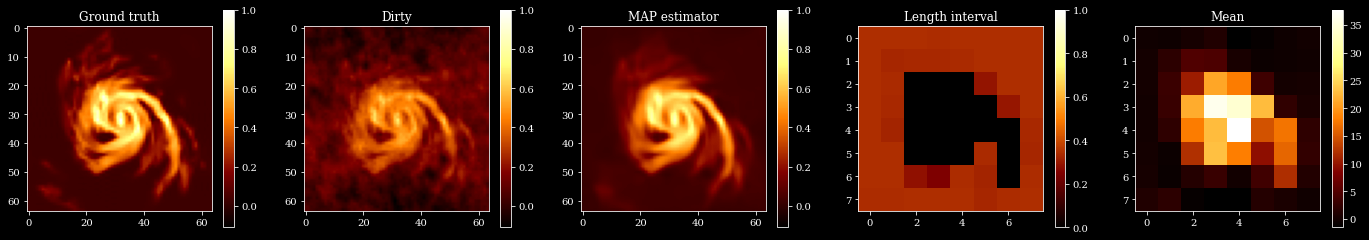

In [117]:

vmin = np.min((x, x_init, x_hat_np))
vmax = np.max((x, x_init, x_hat_np))

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_2, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_2, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_2.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_4, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_4, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_4.pdf')
plt.show()

plt.figure(figsize=(24,4))
plt.subplot(151)
plt.imshow(x, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Ground truth')
plt.subplot(152)
plt.imshow(x_init, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('Dirty')
plt.subplot(153)
plt.imshow(x_hat_np, cmap='afmhot', vmin=vmin, vmax=vmax);plt.colorbar();plt.title('MAP estimator')
plt.subplot(154)
plt.imshow(error_length_8, cmap='afmhot', vmin=0, vmax=vmax);plt.colorbar();plt.title('Length interval')
plt.subplot(155)
plt.imshow(mean_8, cmap='afmhot');plt.colorbar();plt.title('Mean')
plt.savefig('./figs/gal_64_CCR-reg_superpix_8.pdf')
plt.show()

